# Predict Big Mart Sales

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime



In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import math 

In [4]:

#Load Data
df = pd.read_csv('df_bmsales.csv')

### 5.1 Data Splitting, Imputation , Scaling and Encoding

In [5]:
X = df.drop(columns=['Item_Identifier', 'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'MRPperUnit'])
y = df.Item_Outlet_Sales

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [7]:
cat_bins=['a','b','c']

In [8]:
#list of non-numerical columns
cat_list = [
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Type']

In [9]:
#get the unique value by column
Col_ohe=[]
for col in cat_list:
    Col_ohe.extend(list(df[col].unique()))
    

In [10]:
#list of category type columns
blist = ['Outlet_Size','Outlet_Location_Type']

In [11]:
#list of numerical columns
col_list = ['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']
num_list = list(df.drop(columns=col_list).drop(columns=['MRPperUnit','Item_Outlet_Sales', 'Outlet_Establishment_Year'],axis=1))

In [12]:
num_list

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Years_Open']

In [13]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

Bin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#combine numeric and categorical pipelines
preprocess_pipe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_list),
        ('bincat', Bin_transformer, blist),
        ('cat', categorical_transformer, cat_list)
    ])


In [14]:

# fit the pipelines to the training data
preprocess_pipe.fit_transform(X_train)

# apply the pipelines to the training and test data
X_train = preprocess_pipe.transform(X_train)
X_test = preprocess_pipe.transform(X_test)

In [15]:
X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns = (num_list+blist+Col_ohe))
X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns = (num_list+blist+Col_ohe))

### 5.2 Load Model

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor

In [17]:
bst_model = pickle.load(open('bigmart_sales_model.sav', 'rb'))

### 5.3 Model Metrics

### R-squared

In [18]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_r2 = cross_validate(bst_model, X_train, y_train, 
                            scoring='r2', cv=5, n_jobs=-1)

In [19]:
xgb_r2_mean = np.mean(xgb_r2['test_score'])
xgb_r2_std = np.std(xgb_r2['test_score'])
xgb_r2_mean, xgb_r2_std

(0.5954978896622465, 0.01470739531327888)

### MAE

In [20]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_neg_mae = cross_validate(bst_model, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [21]:
xgb_mae_mean = np.mean(-1 * xgb_neg_mae['test_score'])
xgb_mae_std = np.std(-1 * xgb_neg_mae['test_score'])
xgb_mae_mean, xgb_mae_std

(771.7610668405233, 18.74408873629883)

In [22]:
mean_absolute_error(y_test, bst_model.predict(X_test))

739.5567884621183

### MSE

In [23]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_neg_mse = cross_validate(bst_model, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [24]:
xgb_mse_mean = np.mean(-1 * xgb_neg_mse['test_score'])
xgb_mse_std = np.std(-1 * xgb_neg_mse['test_score'])
xgb_mse_mean, xgb_mse_std

(1195779.4336022846, 65331.72914326906)

### RMSE

In [25]:
rmse_mean = (xgb_mse_mean)**(1/2.0)
rmse_std = (xgb_mse_std)**(1/2.0)
rmse_mean, rmse_std

(1093.5170019722075, 255.60072211022617)

### TEST METRICS

In [26]:
y_te_pred =bst_model.predict(X_test)

In [27]:
r2_score(y_test, y_te_pred)

0.6049743924130695

In [28]:
mean_absolute_error(y_test, y_te_pred)

739.5567884621183

In [29]:
mean_squared_error(y_test, y_te_pred)

1106464.1699930101

### 5.4 Feature Importance

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot

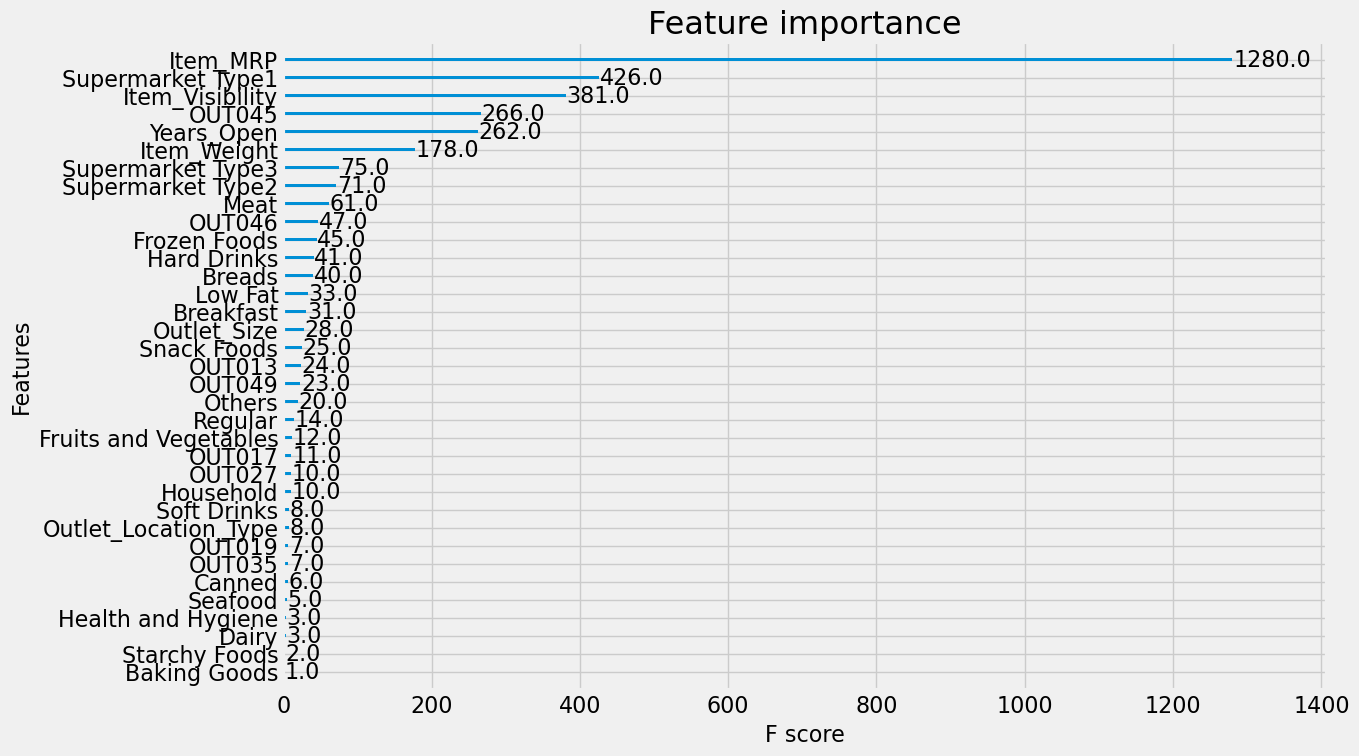

In [31]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

plt.rcParams["figure.figsize"] = (12,8) 
plot_importance(bst_model)
plt.show();